<a href="https://colab.research.google.com/github/adreeja06/-IncludeHer-Projects/blob/master/trainingmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/15_2B.ipynb)

# Packages and Imports
In this tutorial, you will learn how to train different generative models. The following sections will cover "Variational Autoencoders (VAEs)", "Generative Adversarial Networks (GANs)", and "Diffusion Models".

Let's start by installing and importing the packages that we need...

In [1]:
# Install custom packages needed for this notebook

!pip install monai -q
!pip install ipython -q
!pip install rich -q
!pip install denoising_diffusion_pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 10.9 MB/s eta 0:00:00


In [2]:
# Imports

import os
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
from tqdm.auto import tqdm
from rich.progress import track
from scipy import signal
from ipywidgets import interactive, widgets, fixed
import matplotlib.pyplot as plt
import monai as mn
import gdown
from random import shuffle
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

%matplotlib inline

In [3]:
# Seed the entire notebook
# Note: Please note that your notebook outputs may differ from us as
#       seeding with the same seed could result in different behaviours on
#       different hardware that is assigned to your notebook (e.g., GPUs).

def seed_all(random_seed):
    """Use a random_seed to enable deterministic programming for Pytorch, Moani,
      and Numpy and.

    Args:
        random_seed (int): a random_seed to be used by different libraries.
    """
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    mn.utils.misc.set_determinism(seed=random_seed)


seed_all(random_seed=3407)

## Data Preperation
For this notebook we will use a dataset from [Kermany et. al.](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810) that has a set of more than 5,000 pediatric chest radiographs, with and without pneumonia. We use MONAI for dataset preperation, as it has several medical image-specific augmentations and enables using them with a very simple interface.

We create out datasets and dataloaders one here and use it in all of the upcomming experiments. In brief the following cell takes care of the following:

1. Gets the list of files in the train, validation, and test folders of the dataset.
2. Creates a dictionary of these file paths with their corresponding label (normal or pneumonia) to leverage MONAI's dictionary based augmentation pipeline.
3. Defines training and validation transforms.
4. Created datasets and dataloaders for each of the three sets.

In [4]:
# Download the original data

if not os.path.isdir("workshop_data"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1bU-lLDAYZRPTJpaYfrATA7JJ8gwA3HwM",
        "workshop_data.zip",
        quiet=False,
    )
    !mkdir "workshop_data"
    !unzip -q "workshop_data.zip" -d "workshop_data"
    os.remove("workshop_data.zip")

    !mkdir "workshop_data/Original_Dataset"
    !unzip -q "workshop_data/Kermany_Dataset.zip" -d "workshop_data/Original_Dataset"
    os.remove("workshop_data/Kermany_Dataset.zip")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1bU-lLDAYZRPTJpaYfrATA7JJ8gwA3HwM
To: /content/workshop_data.zip
100%|██████████| 1.58G/1.58G [00:14<00:00, 106MB/s]


In [5]:
# Build datasets using MONAI transformations and PersistentDataset

def build_dataset(
    desired_set: str,
    target_size: int = 128,
    augment: bool = True,
    remove_cache: bool = False
) -> mn.data.PersistentDataset:
  """
  Build PyTorch dataloaders based on MONAI dataset.

  Args:
    desired_set (str): The set to build the dataset from. Should be 'train', 'val', or 'test'
    augment (bool): Whether or not to use augmentation in the dataset. Defaults to True.
    target_size (int): An int determining the final size of the image, which is: (target_size, target_size).
      Defaults to 128.
    remove_cache: Whether or not to remove the PersistentDataset cache directory. Defaults to False.
  Returns:
    dl (torch.utils.data.dataloader): The constructed PyTorch dataloader
  """
  # Collect data
  assert desired_set in ['train', 'val', 'test'], "desired_set should be 'train', 'val', or 'test'"
  original_dataset_path = 'workshop_data/Original_Dataset/chest_xray'
  nl_files = [{'Image': f'{original_dataset_path}/{desired_set}/NORMAL/{x}', 'Label': 0.0} for x in os.listdir(f'{original_dataset_path}/{desired_set}/NORMAL') if x.endswith('.jpeg')]
  p_files = [{'Image': f'{original_dataset_path}/{desired_set}/PNEUMONIA/{x}','Label': 1.0} for x in os.listdir(f'{original_dataset_path}/{desired_set}/PNEUMONIA') if x.endswith('.jpeg')]
  files = nl_files + p_files

  # Build transformations
  Aug_Ts = mn.transforms.Compose([
          mn.transforms.LoadImageD(keys=["Image"], image_only=True),
          mn.transforms.EnsureChannelFirstD(keys=["Image"]),
          mn.transforms.LambdaD(keys=["Image"], func=lambda x: x[0, :, :].unsqueeze(0)), # Ensure 1 channel
          mn.transforms.TransposeD(keys=["Image"], indices=[0, 2, 1]),
          mn.transforms.ResizeD(keys=["Image"], spatial_size=(target_size, target_size)),
          mn.transforms.RandZoomD(keys=["Image"], prob=1, min_zoom=0.8, max_zoom=1.1, mode=["bicubic"]),
          mn.transforms.RandRotateD(keys=["Image"], mode=["bicubic"], range_x=0.17, prob=0.8),
          mn.transforms.NormalizeIntensityD(keys=["Image"]),
          mn.transforms.ToTensorD(keys=["Image", "Label"], track_meta=False),
    ])
  NoAug_Ts = mn.transforms.Compose([
          mn.transforms.LoadImageD(keys=["Image"], image_only=True),
          mn.transforms.EnsureChannelFirstD(keys=["Image"]),
          mn.transforms.LambdaD(keys=["Image"], func=lambda x: x[0, :, :].unsqueeze(0)), # Ensure 1 channel
          mn.transforms.TransposeD(keys=["Image"], indices=[0, 2, 1]),
          mn.transforms.ResizeD(keys=["Image"], spatial_size=(target_size, target_size), mode=["bicubic"]),
          mn.transforms.NormalizeIntensityD(keys=["Image"]),
          mn.transforms.ToTensorD(keys=["Image", "Label"], track_meta=False),
    ])
  Ts = Aug_Ts if augment else NoAug_Ts
  cache_dir = f'cache/mn_ps_cache/{desired_set}_{target_size}'
  if remove_cache:
    shutil.rmtree(cache_dir, ignore_errors=True)
  dataset = mn.data.PersistentDataset(data=files, transform=Ts, cache_dir = cache_dir,)
  return dataset

train_ds = build_dataset('train', augment=True, remove_cache=True)
valid_ds = build_dataset('val', augment=False, remove_cache=True)
test_ds = build_dataset('test', augment=False, remove_cache=True)

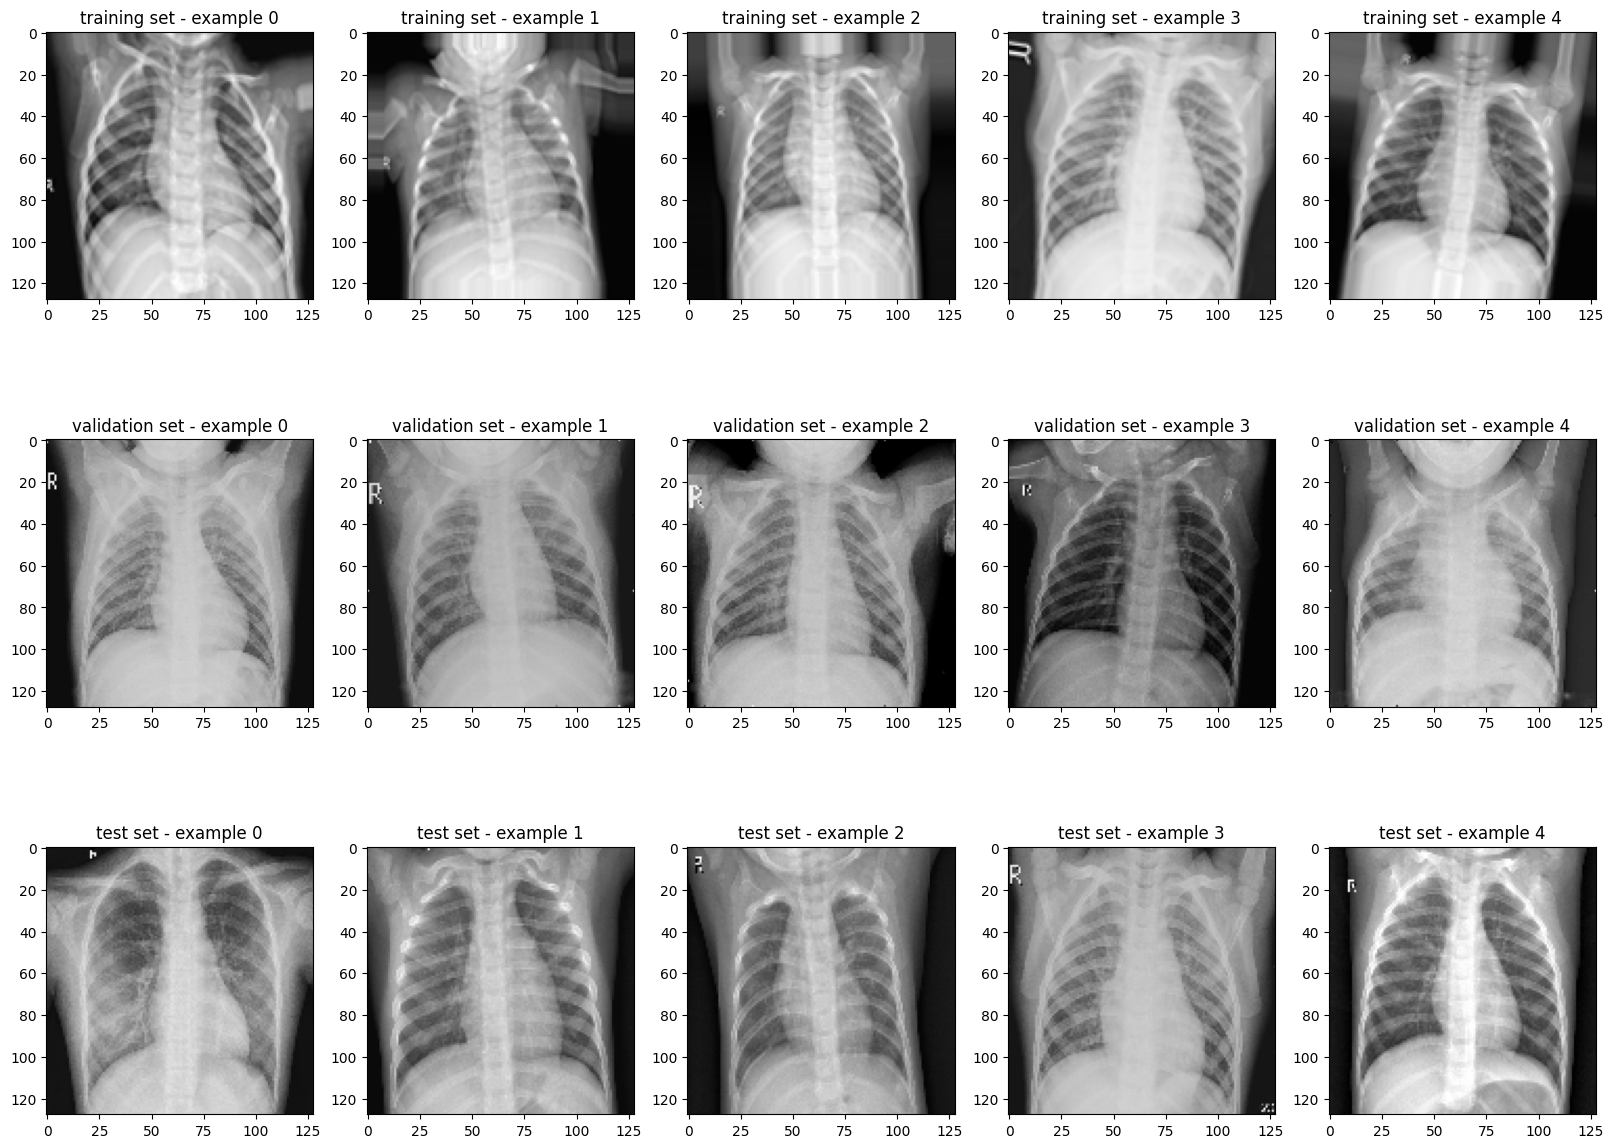

In [6]:
# Build dummy dataloaders and visualize a few images from each

def visualize_dataloaders(train_dl, val_dl, test_dl):
  train_batch_imgs = next(iter(train_dl))['Image']
  val_batch_imgs = next(iter(val_dl))['Image']
  test_batch_imgs = next(iter(test_dl))['Image']
  num_images_to_plot = min(len(train_batch_imgs), len(val_batch_imgs), len(test_batch_imgs), 5)
  fig, axes = plt.subplots(3, num_images_to_plot, figsize=(20, 15))
  for i in range(num_images_to_plot):
    axes[0, i].imshow(train_batch_imgs[i][0], cmap='gray')
    axes[1, i].imshow(val_batch_imgs[i][0], cmap='gray')
    axes[2, i].imshow(test_batch_imgs[i][0], cmap='gray')
    axes[0, i].set_title(f'training set - example {i}')
    axes[1, i].set_title(f'validation set - example {i}')
    axes[2, i].set_title(f'test set - example {i}')

dummy_train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8)
dummy_valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=8)
dummy_test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8)

visualize_dataloaders(dummy_train_dl, dummy_valid_dl, dummy_test_dl)

# Variational Auto Encoders (VAEs)

A variational autoencoder (VAE) is a neural network that, like an autoencoder, learns to reproduce its input and map data to a latent space; however, this latent space is distinct between the two models. Instead of mapping each point of input data to a single vector, the VAE predicts two vectors for each data point (one vector for mean, and the other for the log variance of the latent space distribution). In other words, the VAE will learn to predict the distribution of an ideal latent space rather than a fixed space. During training, we impose a Normal distribution on this latent space, and after training, we generate new images by randomly sampling from this space.

---
>

The cell that follows will define a VAE model. Please take note of how the model generates outputs by randomly sampling the latent space and how we use the reparameterization trick to keep the model's output distinguishable despite this random process.

---

In [7]:
# Define the VAE model

class VAE(nn.Module):
    """Variate Autoencoder model.
    Args:
        latent_dim (int): The dimension of the latent space. Defaults to 512.
    """
    def __init__(self, latent_dim: int=512):
        super().__init__()
        self.latent_dim = latent_dim
        self.feature_map_shape = 32

        #encode layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*(self.feature_map_shape-1)**2, 2*self.latent_dim)
        self.relu = nn.ReLU()
        self.scale = nn.Parameter(torch.tensor([0.0]))

        #decode layers
        self.fc2 = nn.Linear(self.latent_dim, (self.feature_map_shape**2)*32)
        self.conv3 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv5 = nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)

    def encode(self, x: torch.Tensor) -> tuple([torch.Tensor, torch.Tensor]):
        """Encode the input tensor into a latent space representation.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            mean (torch.Tensor): The mean of the latent space representation.
            logvar (torch.Tensor): The log variance of the latent space representation.
        """
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.flatten(x))
        x = self.fc1(x)
        mean, logvar = torch.split(x,self.latent_dim, dim=1)
        return mean, logvar

    def decode(self, eps: torch.Tensor) -> torch.Tensor:
        """Decode the latent space representation into an image.
        Args:
            eps (torch.Tensor): The latent space representation.
        Returns:
            x (torch.Tensor): The reconstructed image.
        """
        x = self.relu(self.fc2(eps))
        x = torch.reshape(x,(x.shape[0], 32, self.feature_map_shape, self.feature_map_shape))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

    def reparamatrize(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        """Reparametrization trick to sample from a normal distribution.
        Args:
            mean (torch.Tensor): The mean of the latent space representation.
            std (torch.Tensor): The standard deviation of the latent space representation.
        Returns:
            q.rsample() (torch.Tensor): The sampled latent space representation.
        """
        # This is equal to: z = mean + std * torch.randn_like(std)
        q = torch.distributions.Normal(mean, std)
        return q.rsample()

    def forward(self, inputs: torch.Tensor) -> tuple([torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]):
        """The forward pass of the model.
        Args:
            inputs (torch.Tensor): The input tensor.
        Returns:
            outputs, z, mean, std (tuple([torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor])): \
                The reconstructed image, the latent space representation, \
                    the mean and the standard deviation of the latent space representation.
        """
        mean, logvar = self.encode(inputs)
        std = torch.exp(0.5 * logvar)
        z = self.reparamatrize(mean, std)
        outputs = self.decode(z)
        return outputs, z, mean, std

inputs = torch.randn(8, 1, 128, 128)
model = VAE()
outputs, z, mean, std =  model(inputs)

inputs.shape, outputs.shape, z.shape, mean.shape, std.shape

(torch.Size([8, 1, 128, 128]),
 torch.Size([8, 1, 128, 128]),
 torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512]))

The VAE loss function will also differ slightly from that of autoencoders. To force the model to learn a Normally distributed latent space, we must add a second loss term (known as the Kullback–Leibler (KL) loss) to the reconstruction loss (which is a simple mean square loss).

In [8]:
# Define the loss function

def vae_loss (inputs: torch.Tensor, outputs: torch.Tensor, mean: torch.Tensor, std: torch.Tensor, kl_weight: float=0.1) -> torch.Tensor:
    """Calculate the loss of the model.
    Args:
        inputs (torch.Tensor): The input tensor.
        outputs (torch.Tensor): The reconstructed image.
        mean (torch.Tensor): The mean of the latent space representation.
        std (torch.Tensor): The standard deviation of the latent space representation.
        kl_weight (float, optional): The weight of the KL divergence loss. Defaults to 0.1.
    Returns:
        loss (torch.Tensor): The loss of the model.
    """
    recon_loss = F.mse_loss(outputs, inputs, reduction='mean')
    kl_loss = -0.5 * torch.mean(torch.sum(1 + std - mean.pow(2) - std.exp(), dim=-1))
    loss = recon_loss + kl_weight * kl_loss
    return loss

vae_loss(inputs, outputs, mean, std)

tensor(19.9963, grad_fn=<AddBackward0>)

Now let's train our VAE and save the best model.

**Note: Running this cell may take several minutes.**

In [9]:
# Train the model

def train_vae(
    model: nn.Module,
    train_ds: mn.data.PersistentDataset,
    valid_ds: mn.data.PersistentDataset,
    NUM_EPOCHS: int=100,
    device: str= 'cuda',
    LR: float=1e-3,
    weight_decay: float=1e-5,
    save_path: str='model.pth'
) -> tuple([nn.Module, list, list]):
    """Train the model.

    Args:
        model (nn.Module): The model to train.
        train_ds (mn.data.PersistentDataset): The training dataset.
        valid_ds (mn.data.PersistentDataset): The validation dataset.
        NUM_EPOCHS (int): The number of epochs to train the model. Defaults to 100.
        device (str): The device to train the model on. Defaults to 'cuda'.
        LR (float): The learning rate of the model. Defaults to 1e-3.
        weight_decay (float): The weight decay of the model. Defaults to 1e-5.
        save_path (str): The path to save the model. Defaults to 'model.pth'.

    Returns:
        model, train_loss_history, valid_loss_history (tuple([nn.Module, list, list]): The trained model, \
            the training loss history and the validation loss history.
    """

    BATCH_SIZE = 32
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=weight_decay)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=False, drop_last=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=False, drop_last=True)
    train_loss_history = []
    valid_loss_history = []
    best_loss = torch.inf
    model = model.to(device)

    for epoch in range(NUM_EPOCHS):
        print(f'{"-"*50}\nEpoch {epoch+1}/{NUM_EPOCHS}')
        time.sleep(0.5)

        # Training loop
        batch_loss = []
        model.train()
        for batch in track(train_dl, description='Training'):
            optimizer.zero_grad()
            inputs = batch['Image'].to(device)
            outputs, z, mean, std = model(inputs)
            loss = vae_loss(inputs, outputs, mean, std)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        train_epoch_loss = torch.mean(torch.Tensor(batch_loss))
        train_loss_history.append(train_epoch_loss)

        # Validation loop
        batch_loss = []
        model.eval()
        for batch in track(test_dl, description='Validation'):
            with torch.no_grad():
                inputs = batch['Image'].to(device)
                outputs, z, mean, std = model(inputs)
                loss = vae_loss(inputs, outputs, mean, std)
                batch_loss.append(loss.item())
        valid_epoch_loss = torch.mean(torch.Tensor(batch_loss))
        valid_loss_history.append(valid_epoch_loss)

        # Logging and saving the model
        print(f'Training loss: {train_epoch_loss:.4f}')
        print(f'Validation loss: {valid_epoch_loss:.4f}')
        if valid_epoch_loss < best_loss:
            best_loss = valid_epoch_loss
            torch.save(model.state_dict(), save_path)
            print('New best model saved!')

    return model, train_loss_history, valid_loss_history

VAE_WEIGHT_PATH = 'model.pth'
model = VAE()
model, train_loss_history, valid_loss_history = train_vae(model, train_ds, test_ds, NUM_EPOCHS=1, save_path=VAE_WEIGHT_PATH)

--------------------------------------------------
Epoch 1/1


Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

Output()

Training loss: 5.8196
Validation loss: 0.2763
New best model saved!


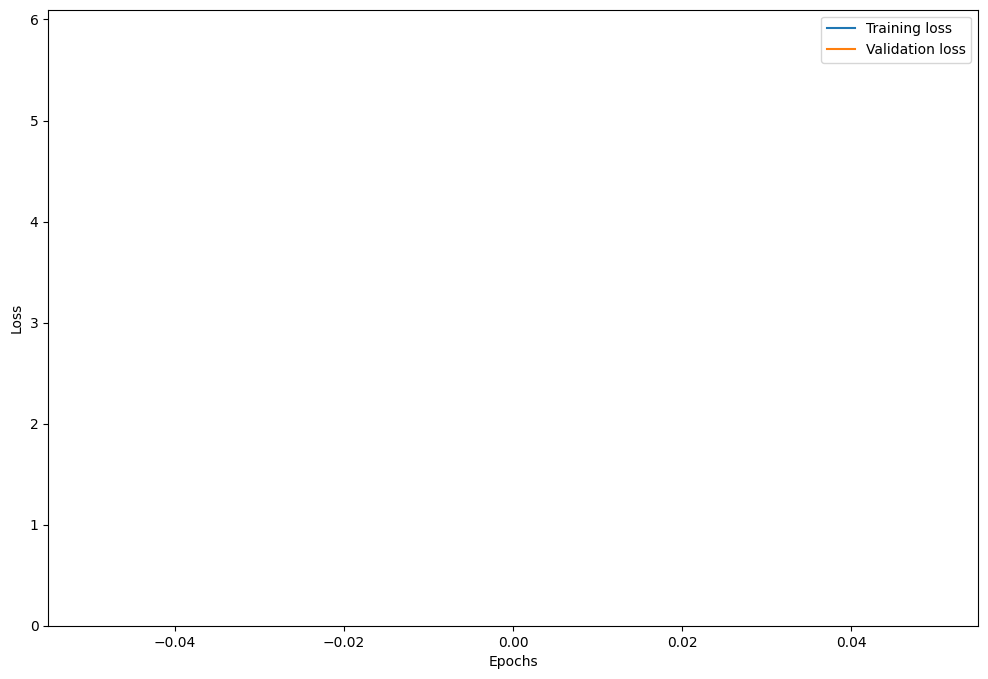

In [10]:
# Plot the loss curves

def plot_vae_loss_curves(train_loss_history: list, valid_loss_history: list):
    """Plot the loss curves of the model.
    Args:
        train_loss_history (list): The training loss history.
        valid_loss_history (list): The validation loss history.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(valid_loss_history, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_vae_loss_curves(train_loss_history, valid_loss_history)

Since our latent space is two-dimensional, we can use the encoder to transform a batch of input data and generate a scatterplot of the output vectors. Please note that distinct colors represent distinct classes.

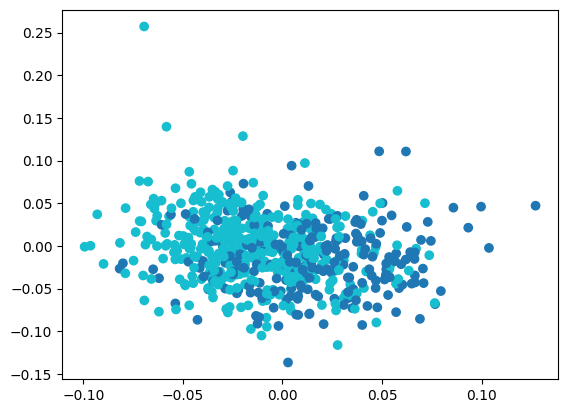

In [11]:
# Visuzalize the latent space with the two classes represented by different colors

def plot_latent(model: nn.Module,
                dl: torch.utils.data.DataLoader,
                max_num_batches: int=100,
                device: str='cuda'):
    """Plot the latent space of the model.
    Args:
        model (nn.module): The model to plot the latent space of.
        dl (torch.utils.data.DataLoader): The dataloader to use for the plot.
        max_num_batches (int): The maximum number of batches to plot. Defaults to 100.
        device (str): The device to use for the plot. Defaults to 'cuda'.
    """
    for i, batch in enumerate(dl):
        model = model.to(device)
        x = batch['Image'].to(device)
        y = batch['Label'].to('cpu').detach().numpy()
        _, z, _, _ = model(x)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > max_num_batches:
            plt.colorbar()
            break

model = VAE()
model.load_state_dict(torch.load(VAE_WEIGHT_PATH))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=False, drop_last=True)
plot_latent(model, test_dl)

We can finally generate new samples by randomly sampling our latent space. Please note that this can be done with or without using a batch of actual data as the input for the encoder model. If we do not feed any actual data, we should only sample a random latent vector and let the decoder bring it back to the image space; if we use the actual data, we will first obtain the latent vector distribution from the actual data, then sample this distribution randomly, and feed it to our decoder. Clearly, the image quality will be superior in the later case (but why?).

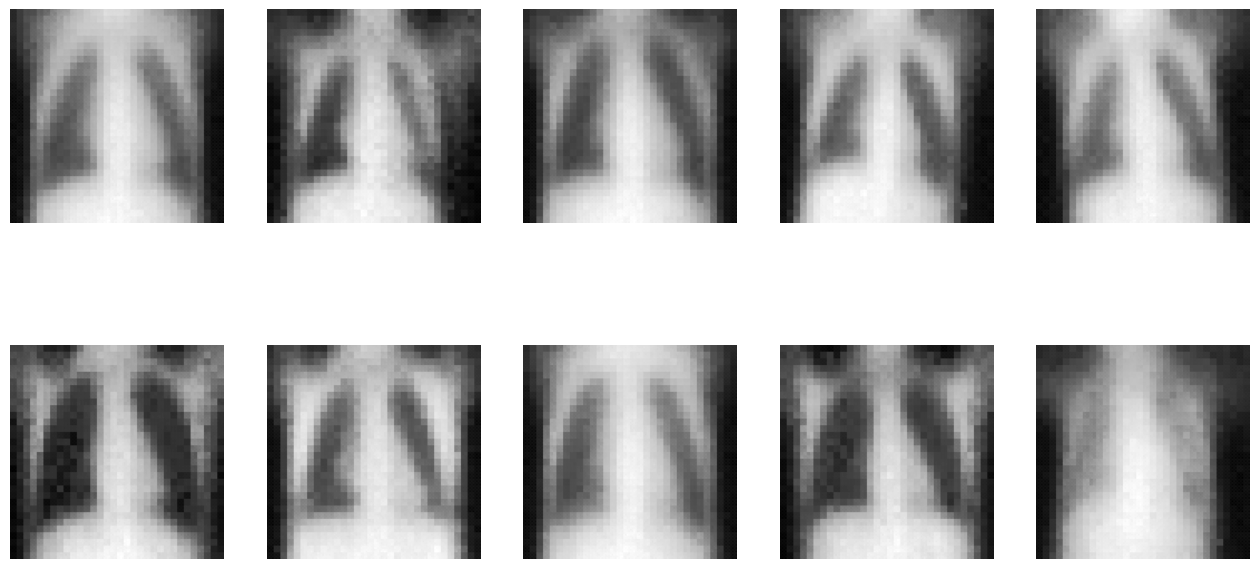

In [12]:
# Generate new images

def generate_new_images(
    model: nn.Module,
    num_images: int=10,
    device: str='cuda',
    ds: mn.data.PersistentDataset=None
):
    """Generate new images using the VAE model.
    Args:
        model (nn.Module): The model to use for generating the images.
        num_images (int, optional): Number of images to generate. Defaults to 10.
        device (str, optional): The device to use for generating the images. Defaults to 'cuda'.
        ds (mn.data.PersistentDataset, optional): The dataset to use for generating the images.
            Defaults to None, which generates images from random noise.
    """
    model = model.to(device)
    if ds==None:
        z = torch.randn(num_images, model.latent_dim).to(device)
        outputs = model.decode(z)
    else:
        dl = torch.utils.data.DataLoader(ds, batch_size=num_images, shuffle=True, num_workers=0, pin_memory=False, drop_last=True)
        inputs = next(iter(dl))['Image'].to(device)
        outputs, _, _, _ = model(inputs)

    outputs = outputs.to('cpu').detach().numpy()
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(outputs[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

model = VAE()
model.load_state_dict(torch.load(VAE_WEIGHT_PATH))
generate_new_images(model, ds=test_ds)

#Generative Adversarial Networks (GANs)

In this section, we train a GAN on a set of synthetic data and then will run inference on an already trained algorithm to generate medical images.

In [13]:
import os
import random
import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import signal
from ipywidgets import interactive, widgets, fixed

import matplotlib.pyplot as plt
%matplotlib inline

Due to computational constraints on Colab, we use a simple two-dimensional dataset. In this example, we try to train a GAN to approximate a sawtooth function as follows:

In [14]:
def sawtooth_fn(x):
    y = signal.sawtooth(x, 0.5)
    return x, y

FUNCTION = sawtooth_fn

Let's plot to see what our function looks like:

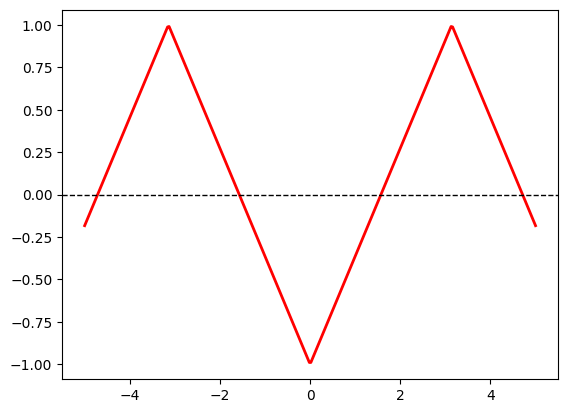

In [15]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# we define min and max of the generated range
MIN_RANGE = -5
MAX_RANGE = 5

def plot_function(function):
    x = np.linspace(MIN_RANGE, MAX_RANGE, 300)
    x, y = function(x)
    plt.plot(x, y, 'r', linewidth=2)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')

plot_function(FUNCTION)

We can now proceed with creating our networks:

In [16]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, output_dim),
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim//2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim//2, 1),
            torch.nn.Sigmoid() # binary output
        )

    def forward(self, x):
        return self.model(x)

You see that both the `Generator` and `Discriminator` classes have roughly the same architecture with two main differences:



1.  **Input Shape**:

*   The input to the generator is a noise vector with the shape `(batch, latent_dim)`.
*   The input to the discriminator is a pair of numbers (x,y), resulting to a shape of `(batch, 2)`.


2.  **Output Shape**:

*   The generator outputs a pair of numbers, *just like the input of the discriminator*, with the shape `(batch, 2)`.
*   The output to the discriminator is a single number for each input showing how real an input pair is.

Now we can create our two networks and their optimizers:

In [17]:
generator = Generator(latent_dim=10, hidden_dim=200, output_dim=2).to(DEVICE)
discriminator = Discriminator(input_dim=2, hidden_dim=100).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()

The following are some helper functions that we will use for this section:

In [18]:
def seed_all(seed:int) -> None:
    """Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): seed to use
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_real_data(batch_size:int) -> torch.Tensor:
    """get real data from the function

    Args:
        batch_size (int): number of samples

    Returns:
        torch.Tensor: batch of real data (batch_size, 2)
    """
    x = np.random.uniform(MIN_RANGE, MAX_RANGE, batch_size)
    x, y = FUNCTION(x)
    return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)

def get_noise(batch_size: int, latent_dim:int) -> torch.Tensor:
    """_summary_

    Args:
        batch_size (int): number of samples
        latent_dim (int): latent dimension of the noise

    Returns:
        torch.Tensor: batch of noise (batch_size, latent_dim)
    """
    return torch.randn(batch_size, latent_dim)

def generate_fake_samples(generator:torch.nn.Module, num_samples:int) -> torch.Tensor:
    """generate fake samples from the generator

    Args:
        generator (torch.Module): generator model
        num_samples (int): number of samples

    Returns:
        torch.Tensor: batch of fake data (batch_size, 2)
    """
    generator.eval()
    noise = get_noise(num_samples, generator.latent_dim).to(DEVICE)
    with torch.no_grad():
        fake_data = generator(noise).detach().cpu().numpy()
    return fake_data

def plot_generated_data(synthetic_data:np.ndarray, title:str = "Generated Data"):
    """Plot the synthetic data and the original function.

    Args:
        synthetic_data (np.ndarray): synthetic data generated by the generator.
        title (str, optional): the title of the plot. Defaults to "Generated Data".
    """
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=4)
    plt.title(title)
    plot_function(FUNCTION)
    plt.show()

def plot_log_images(iteration: int, data_log:list) -> None:
    """Plot the generated data at a specific iteration.

    Args:
        iteration (int): iteration number
        data_log (list): list of the generated data at each iteration
    """
    idx = iteration//100
    plot_generated_data(data_log[idx], title=f"Iteration #{iteration}")
    plt.show()

The main training function for our GAN is:

In [19]:
def train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size, train_iterations=10000) -> [list, list, list]:
    """Train the GAN model

    Args:
        generator (torch.nn.Module): generator model
        discriminator (torch.nn.Module): discriminator model
        gen_optimizer (torch.optim): generator optimizer
        disc_optimizer (torch.optim): discriminator optimizer
        loss_fn (torch.nn): loss function
        batch_size (int): batch size
        train_iterations (int, optional): number of training iterations. Defaults to 10000.

    Returns:
        gen_loss_history: list of generator losses
        disc_loss_history: list of discriminator losses
        data_log: list of generated data at each 100 iterations
    """
    disc_loss_history = []
    gen_loss_history = []
    data_log = []
    for iter in tqdm(range(train_iterations)):
        # Train discriminator
        disc_optimizer.zero_grad()
        real_data = get_real_data(batch_size).to(DEVICE)
        disc_real_pred = discriminator(real_data)
        disc_real_loss = loss_fn(disc_real_pred, torch.ones_like(disc_real_pred)) # real data should have label 1
        disc_real_loss.backward()

        noise = get_noise(batch_size, generator.latent_dim).to(DEVICE)
        fake_data = generator(noise)
        disc_fake_pred = discriminator(fake_data)
        disc_fake_loss = loss_fn(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # fake data should have label 0
        disc_fake_loss.backward()

        disc_loss = (disc_real_loss + disc_fake_loss)/2
        disc_loss_history.append(disc_loss.item())
        disc_optimizer.step()

        # Train generator
        gen_optimizer.zero_grad()
        noise = get_noise(batch_size, generator.latent_dim).to(DEVICE)
        fake_data = generator(noise)
        disc_fake_pred = discriminator(fake_data)
        gen_loss = loss_fn(disc_fake_pred, torch.ones_like(disc_fake_pred)) # generator wants discriminator to think fake data is real
        gen_loss.backward()
        gen_loss_history.append(gen_loss.item())
        gen_optimizer.step()

        if (iter+1)%100 == 0 or iter == 0:

            synthetic_samples = generate_fake_samples(generator, 1000)
            data_log.append(synthetic_samples)

    return gen_loss_history, disc_loss_history, data_log

Let's start training our GAN to see if it can approximate our original function.

In [20]:
seed_all(10922)
gen_loss_history, disc_loss_history, data_log = train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size=100, train_iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

We can check our model's progress throughout the training:

In [21]:
interactive_plot = interactive(
    plot_log_images,
    iteration=widgets.IntSlider(min=0, max=(len(data_log)-1)*100, step=100, value=0),
    data_log=fixed(data_log),
)
interactive_plot

interactive(children=(IntSlider(value=0, description='iteration', max=10000, step=100), Output()), _dom_classe…

Now let's try a more sophisticated function:

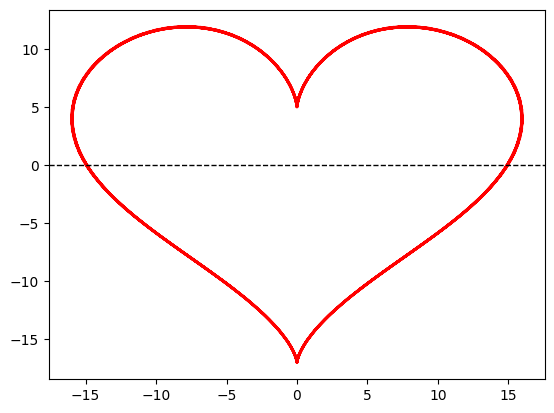

In [22]:
MIN_RANGE = -15
MAX_RANGE = 15

def heart_fn(theta):
    x = 16 * (np.sin(theta) ** 3)
    y = 13 * np.cos(theta) - 5* np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)

    return x,y

FUNCTION = heart_fn
plot_function(FUNCTION)

Will our GAN learn to approximate this function?

In [23]:
generator = Generator(latent_dim=10, hidden_dim=200, output_dim=2).to(DEVICE)
discriminator = Discriminator(input_dim=2, hidden_dim=100).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
loss_fn = torch.nn.BCELoss()

seed_all(10922)
gen_loss_history, disc_loss_history, data_log = train_gan(generator, discriminator, gen_optimizer, disc_optimizer, loss_fn, batch_size=100, train_iterations=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]



<font size="3" color="red"><b>Question:</b></font> How is this different than a supervised model?

<details>

<summary>
<font size="3" color="green">
<b>Answer: <font size="2" color="orange"><i>Click here to see if your answer is correct.<i></font></b>
</font>
</summary>

In a supervised task, the model will get an input and try to generate an output that is compared with a ground truth; in other words, the model will get `x` and then try to find out the corresponding `y`. However, for the GAN training, tho model generated *pairs* of `x,y` and the generator validates these pairs.
</details>



Now, let's see how our model tackled this problem.

In [24]:
interactive_plot = interactive(
    plot_log_images,
    iteration=widgets.IntSlider(min=0, max=(len(data_log)-1)*100, step=100, value=0),
    data_log=fixed(data_log),
)
interactive_plot

interactive(children=(IntSlider(value=0, description='iteration', max=20000, step=100), Output()), _dom_classe…

This is a very good performance for only three linear layers, highlighting the power of the discriminator's feedback in shaping the generator's output.

Now, we can proceed with an already trained model GAN ([StyleGAN v3](https://github.com/NVlabs/stylegan3)) that generates medical images:

In [25]:
import gdown
import os

if not os.path.isdir("workshop_data"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1bU-lLDAYZRPTJpaYfrATA7JJ8gwA3HwM",
        "workshop_data.zip",
        quiet=False,
    )
    !mkdir "workshop_data"
    !unzip -q "workshop_data.zip" -d "workshop_data"
    os.remove("workshop_data.zip")

if not os.path.exists("stylegan3"):
    !git clone https://github.com/BardiaKh/stylegan3.git # a fork that is compatible with latest pytorch
    !pip install ninja
    !pip install imageio-ffmpeg
else:
    print("Requirements are already installed.")

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 4.16 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (105/105), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 5.7 MB/s eta 0:00:00


/content/stylegan3


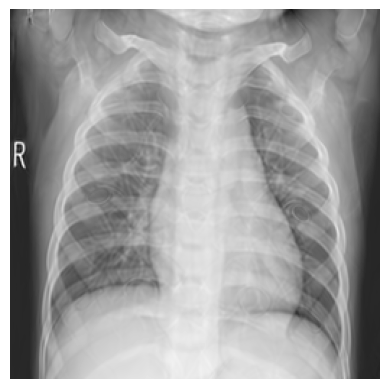

In [27]:
#@title Generate Conditional Samples

%cd "/content/stylegan3"

class_label = "Normal" #@param ["Normal", "Viral Pneumonia", "Bacterial Pneumonia"]

import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

with open('/content/workshop_data/256_styleganv3t_7M.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(DEVICE)

z = torch.randn([1, G.z_dim]).to(DEVICE)    # noise vector
psi = 0.7
c = {"Normal":0, "Viral Pneumonia":1, "Bacterial Pneumonia":2}[class_label]
c = torch.nn.functional.one_hot(torch.tensor(c), num_classes=3)
c = c.float().unsqueeze(0).to(DEVICE)
img = G(z, c, psi).detach().cpu()
plt.imshow(img[0,0], cmap='gray');
plt.axis('off');

#Diffusion Models

In this section using denoising_diffusion_pytorch package we will train a DDPM model.

DDPM models work based forward and backward processes.
Let's review the forward process.

In [29]:
import gdown
import os

# Define the download URL and target file paths
download_url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1NO0qn0x7qKigTMa9f5_Ejs_3AsUm43l6"
zip_file_path = "Transformed_dataset_3channels.zip"
extract_to_path = "workshop_data/Original_Dataset/three_channels"

# Create target directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Download the file from Google Drive
gdown.download(download_url, zip_file_path, quiet=False)

# Unzip the downloaded file to the specified directory
os.system(f'unzip -q "{zip_file_path}" -d "{extract_to_path}"')

# Remove the zip file
os.remove(zip_file_path)


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1NO0qn0x7qKigTMa9f5_Ejs_3AsUm43l6
To: /content/stylegan3/Transformed_dataset_3channels.zip
100%|██████████| 1.33M/1.33M [00:00<00:00, 12.0MB/s]


In [34]:
import gdown
import os

# Define the download URL and target file paths
download_url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1NO0qn0x7qKigTMa9f5_Ejs_3AsUm43l6"
zip_file_path = "Transformed_dataset_3channels.zip"
extract_to_path = "workshop_data/Original_Dataset/three_channels/Transformed_dataset_3channels"

# Create target directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Download the file from Google Drive
gdown.download(download_url, zip_file_path, quiet=False)

# Unzip the downloaded file to the specified directory
os.system(f'unzip -q "{zip_file_path}" -d "{extract_to_path}"')

# Remove the zip file
os.remove(zip_file_path)

# List files in the directory to confirm extraction
files = os.listdir(extract_to_path)
print("Extracted files:", files)


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1NO0qn0x7qKigTMa9f5_Ejs_3AsUm43l6
To: /content/stylegan3/Transformed_dataset_3channels.zip
100%|██████████| 1.33M/1.33M [00:00<00:00, 11.4MB/s]

Extracted files: ['NORMAL2-IM-1422-0001.jpeg', 'Transformed_dataset_3channels', 'NORMAL2-IM-1406-0001.jpeg', 'NORMAL2-IM-1401-0001.jpeg', 'NORMAL2-IM-1419-0001.jpeg', 'NORMAL2-IM-1423-0001.jpeg', 'NORMAL2-IM-1412-0001.jpeg', 'NORMAL2-IM-1385-0001.jpeg', 'NORMAL2-IM-1379-0001.jpeg', 'NORMAL2-IM-1396-0001.jpeg', 'NORMAL2-IM-1400-0001.jpeg']


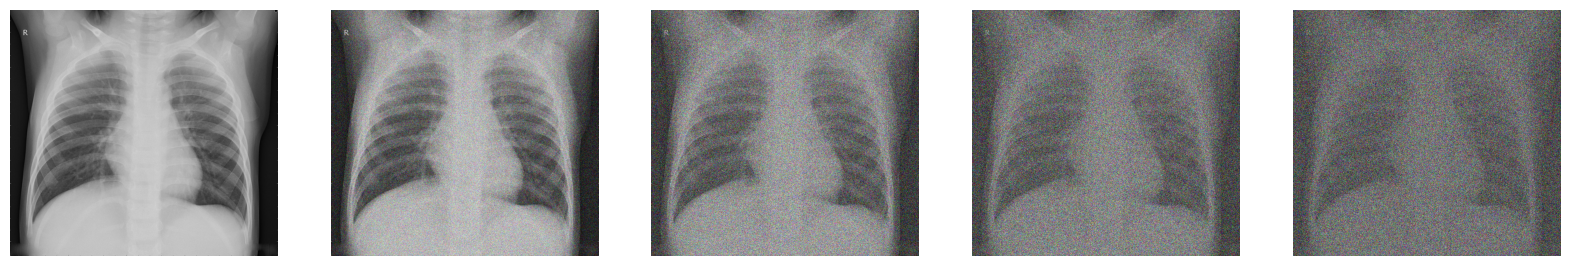

In [35]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

def gather(consts: torch.Tensor, t: torch.Tensor):
    """
    Gathers constants for `t` from `consts` tensor and reshapes them to have a feature map shape.

    Args:
        consts (torch.Tensor): A tensor of constants.
        t (torch.Tensor): A tensor of indices.

    Returns:
        torch.Tensor: A tensor containing the constants for the indices specified in `t`, reshaped to have a shape
        of (-1, 1, 1), where -1 indicates that the first dimension is inferred from the shape of the input tensor.
    """
    c = consts[t]
    return c.reshape(-1, 1, 1)

n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
    """
    Calculates the current value of q based on the given previous value (xtm1) and time step (t).

    Args:
        xtm1 (torch.Tensor): A tensor representing the previous value of q at time step t-1.
        t (int): An integer representing the current time step.

    Returns:
        torch.Tensor: A tensor representing the current value of q at time step t.
    """
    mean = gather(1. - beta, t) ** 0.5 * xtm1  # √(1−βt)*xtm1
    var = gather(beta, t)  # βt
    eps = torch.randn_like(xtm1)  # Noise shaped like xtm1
    return mean + (var ** 0.5) * eps

# Show images at different stages
ims = []
img_path = os.path.join("workshop_data/Original_Dataset/three_channels/Transformed_dataset_3channels", 'NORMAL2-IM-1379-0001.jpeg')

# Check if the file exists
if os.path.exists(img_path):
    cxr = Image.open(img_path).convert('RGB')
    cxr = np.array(cxr)
    cxr = cxr / 255.0  # Normalize to [0, 1]
    x = torch.tensor(cxr).permute(2, 0, 1).float()

    # Ensure the tensor is in the correct shape
    if x.ndim == 3:
        x = x.unsqueeze(0)  # Add batch dimension

    for t in range(n_steps):
        # Store images every 20 steps to show progression
        if t % 20 == 0:
            ims.append(x.squeeze().permute(1, 2, 0).numpy())

        # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
        t_tensor = torch.tensor(t, dtype=torch.long)  # t as a tensor
        x = q_xt_xtminus1(x, t_tensor)  # Modify x using our function above

    # Plot the images
    fig, axes = plt.subplots(1, len(ims), figsize=(20, 20))
    for i, img in enumerate(ims):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()
else:
    print(f"File not found: {img_path}")


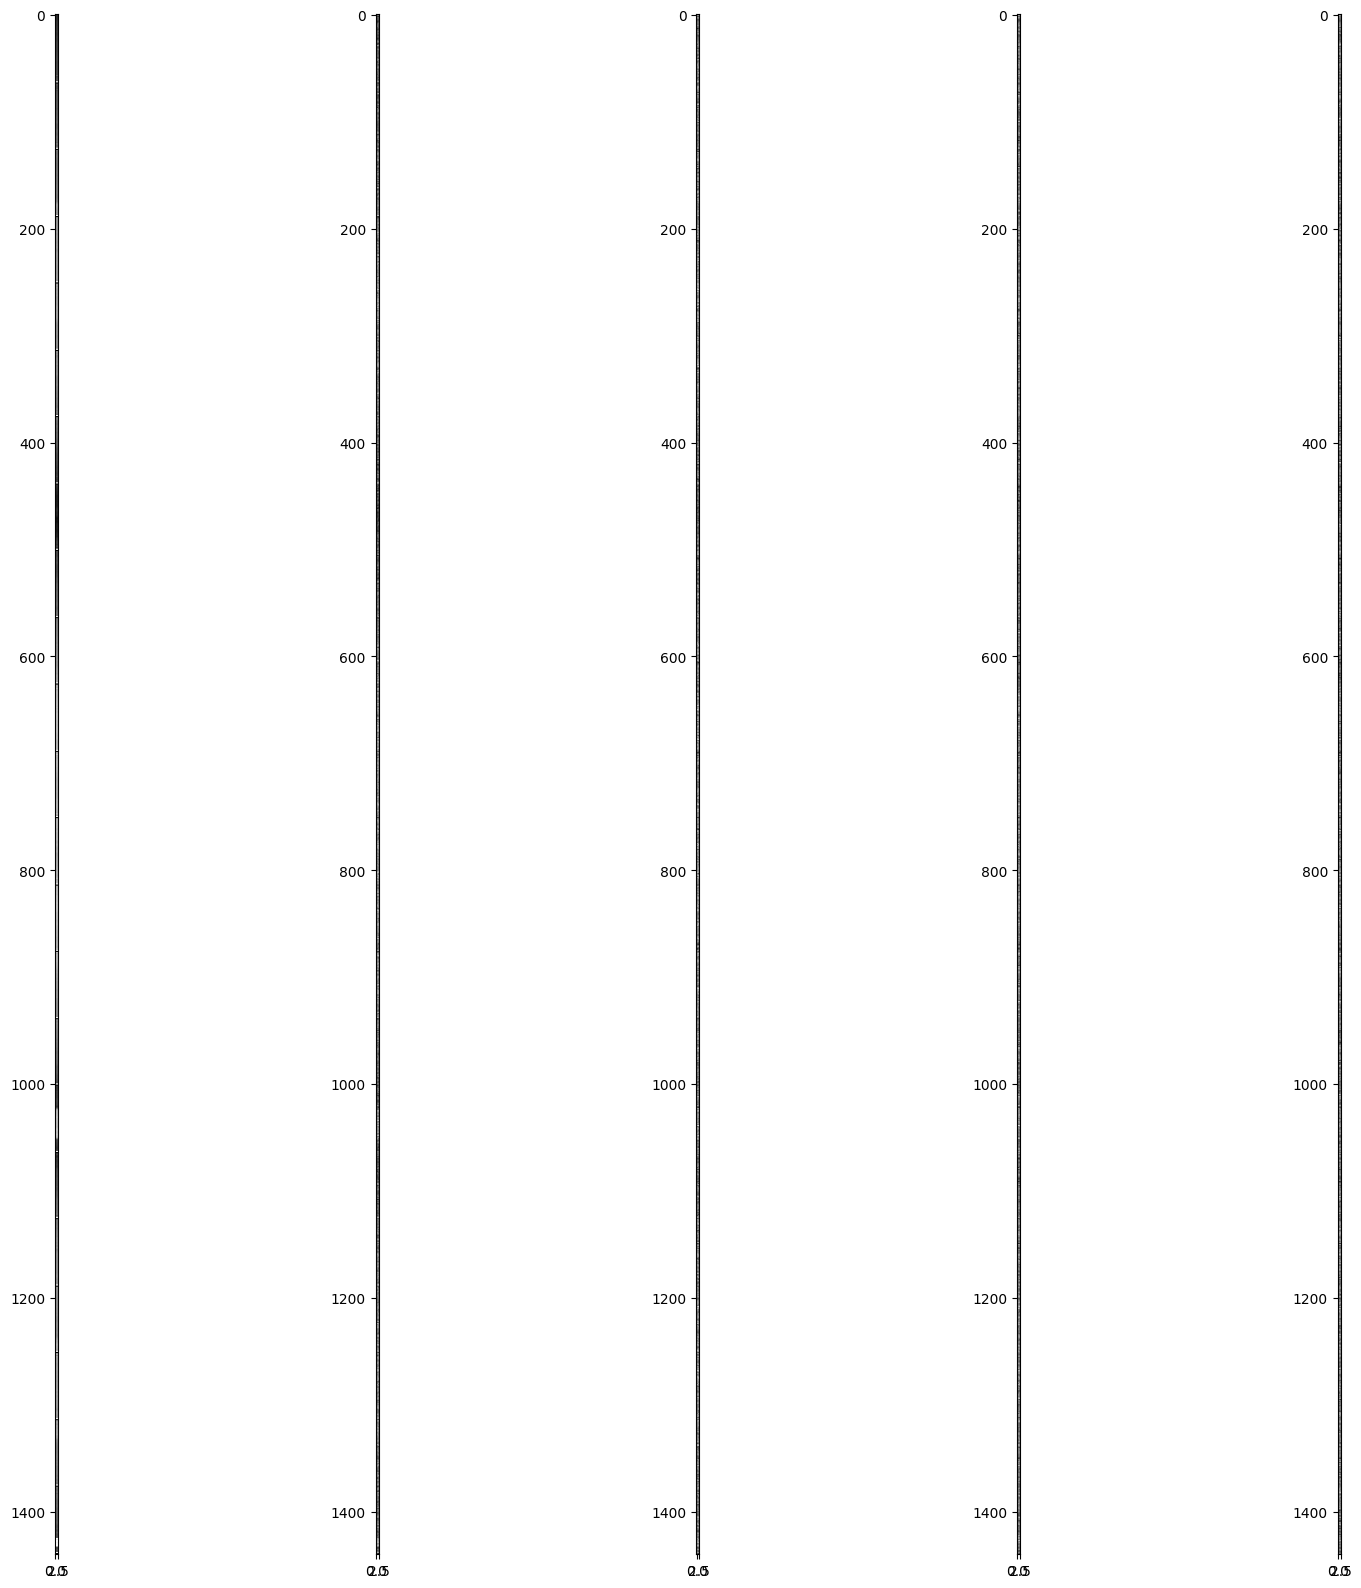

In [36]:
fig,axes=plt.subplots(1,5,figsize=(20,20))
for k in range(5):
    axes[k].imshow(ims[k][0,:,:],cmap='gray')

In [38]:
!nvidia-smi


Fri Jun 14 15:46:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              34W /  70W |   2013MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [52]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os

# Define your UNet model with proper upsampling
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Sigmoid()  # Adjust activation function based on your task
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x = self.decoder(x1)
        return x

# Define your diffusion model
class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps, sampling_timesteps):
        super(GaussianDiffusion, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.sampling_timesteps = sampling_timesteps

    def forward(self, x):
        # Implement diffusion logic here using self.timesteps and self.sampling_timesteps
        return self.model(x)

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        # Initialize dataset here

    def __len__(self):
        return 100  # Dummy length, replace with actual length

    def __getitem__(self, idx):
        # Dummy implementation, replace with actual data loading
        input_data = torch.randn(3, 128, 128)  # Example input tensor
        target = torch.randint(0, 2, (1, 128, 128)).float()  # Example binary mask target
        return input_data, target

# Define your trainer class
class Trainer:
    def __init__(self, diffusion_model, folder, train_batch_size, train_lr, save_and_sample_every, train_num_steps, gradient_accumulate_every, ema_update_every, ema_decay, adam_betas, amp):
        self.diffusion_model = diffusion_model
        self.folder = folder
        self.train_batch_size = train_batch_size
        self.train_lr = train_lr
        self.save_and_sample_every = save_and_sample_every
        self.train_num_steps = train_num_steps
        self.gradient_accumulate_every = gradient_accumulate_every
        self.ema_update_every = ema_update_every
        self.ema_decay = ema_decay
        self.adam_betas = adam_betas
        self.amp = amp

        # Initialize dataset and dataloader
        self.dataset = CustomDataset(folder)
        self.dataloader = DataLoader(self.dataset, batch_size=train_batch_size, shuffle=True)

        # Initialize optimizer and loss function
        self.optimizer = torch.optim.Adam(self.diffusion_model.parameters(), lr=train_lr, betas=adam_betas)
        self.loss_fn = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification

    def train(self):
        print(f"Training for {self.train_num_steps} steps...")
        for step in range(1, self.train_num_steps + 1):
            for batch in self.dataloader:
                inputs, targets = batch
                inputs = inputs.cuda()
                targets = targets.cuda()  # Move targets to GPU

                # Forward pass
                outputs = self.diffusion_model(inputs)

                # Ensure outputs and targets have the same shape
                if outputs.shape != targets.shape:
                    raise ValueError(f"Output shape {outputs.shape} does not match target shape {targets.shape}")

                loss = self.loss_fn(outputs, targets)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update exponential moving average (EMA) of model parameters
                if step % self.ema_update_every == 0:
                    self.update_ema()

                # Log training progress
                if step % self.save_and_sample_every == 0:
                    print(f"Step {step}/{self.train_num_steps}, Loss: {loss.item()}")

    def update_ema(self):
        # Dummy method, replace with actual implementation
        pass


# Main script to define and run the training process
if __name__ == "__main__":
    # Ensure necessary directories exist
    data_folder = '/content/workshop_data/Original_Dataset/three_channels/Transformed_dataset_3channels'
    os.makedirs(data_folder, exist_ok=True)

    # Define the UNet model
    model = Unet(
        in_channels=3,      # Adjust based on your input channels (e.g., 3 for RGB)
        out_channels=1      # Adjust based on your output channels (e.g., 1 for binary segmentation)
    ).cuda()

    # Define the diffusion module
    diffusion = GaussianDiffusion(
        model=model,
        timesteps=1000,            # Adjust based on your diffusion process requirements
        sampling_timesteps=250,    # Adjust based on your sampling timesteps
    ).cuda()

    # Define the trainer module
    trainer = Trainer(
        diffusion_model=diffusion,
        folder=data_folder,
        train_batch_size=32,
        train_lr=8e-5,
        save_and_sample_every=10,
        train_num_steps=100,
        gradient_accumulate_every=2,
        ema_update_every=10,
        ema_decay=0.995,
        adam_betas=(0.9, 0.999),
        amp=True
    )

    # Start training
    trainer.train()


Training for 100 steps...
Step 10/100, Loss: 0.6951720118522644
Step 10/100, Loss: 0.6951334476470947
Step 10/100, Loss: 0.6947299242019653
Step 10/100, Loss: 0.6947999596595764
Step 20/100, Loss: 0.6931964159011841
Step 20/100, Loss: 0.6932350993156433
Step 20/100, Loss: 0.6932435035705566
Step 20/100, Loss: 0.6932134628295898
Step 30/100, Loss: 0.6931824684143066
Step 30/100, Loss: 0.6931818127632141
Step 30/100, Loss: 0.6932035684585571
Step 30/100, Loss: 0.6931842565536499
Step 40/100, Loss: 0.6931695938110352
Step 40/100, Loss: 0.6931682229042053
Step 40/100, Loss: 0.693183183670044
Step 40/100, Loss: 0.6931706666946411
Step 50/100, Loss: 0.6931619644165039
Step 50/100, Loss: 0.6931699514389038
Step 50/100, Loss: 0.6931610703468323
Step 50/100, Loss: 0.6931849122047424
Step 60/100, Loss: 0.6931588649749756
Step 60/100, Loss: 0.6931551694869995
Step 60/100, Loss: 0.6931442022323608
Step 60/100, Loss: 0.6931785345077515
Step 70/100, Loss: 0.6931517720222473
Step 70/100, Loss: 0.6931

Thank you for taking part in this tutorial!

Contact Information
Shahriar Faghani

Twitter: @ShahriarFaghani
Email: Faghani.shahriar@mayo.edu
Pouria Rouzrokh

Twitter: @PRouzrokh
Email: Rouzrokh.pouria@mayo.edu
Bardia Khosravi

Twitter: @khosravi_bardia
Email: Khosravi.bardi@mayo.edu
Mana Moassefi

Twitter: @ManaMSF94
Email: Moassefi.mana@mayo.edu